![](https://github.com/IntelRealSense/librealsense/raw/master/doc/img/realsense.png)


## Introduction

The notebook offers a quick hands-on introduction to Intel RealSense Depth-Sensing technology. 

> **Have a Question?** [Open new issue on our GitHub](https://github.com/IntelRealSense/librealsense/issues/new)

## The Tools
We are planning to use the following packages:

In [4]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library which produces publication quality figures
from pyntcloud.pyntcloud import PyntCloud # open source library for 3D pointcloud visualisation
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
print("Environment Ready")

Environment Ready


## The API
Next, we will open depth and RGB streams from pre-recorded file and capture a set of frames:


In [25]:
# Setup:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file("object_detection.bag")
profile = pipe.start(cfg)

# Skip 5 first frames to give the Auto-Exposure time to adjust
for x in range(5):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured")

Frames Captured


## RGB Data
Let's start with accessing the color componnent of the frameset:

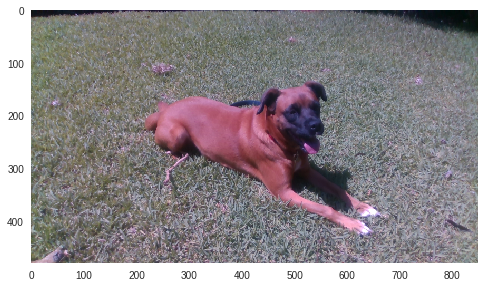

In [4]:
color = np.asanyarray(color_frame.get_data())
plt.rcParams["axes.grid"] = False
plt.imshow(color)

## Depth Data
Now, we will visualize the depth map captured by the RealSense camera:

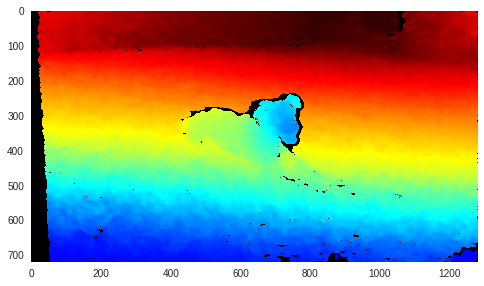

In [5]:
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth)

## Stream Alignment
Upon closer inspection you can notice that the two frames are not captured from the same physical viewport.

To combine them into a single RGBD image, let's align depth data to color viewport:

In [0]:
# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())

# Show the two frames together:
images = np.hstack((color, colorized_depth))
plt.imshow(images)

Now the two images are pixel-perfect aligned and you can use depth data just like you would any of the other channels.

In [0]:
pointcloud = rs.pointcloud()
pointcloud.map_to(color_frame);
pc = pointcloud.calculate(depth_frame);
pc.export_to_ply("1.ply", color_frame);
anky = PyntCloud.from_file("1.ply");
anky.plot(backend="pythreejs", background="white")

## Object Detection

Next, we will take advantage of widely popular **MobileNet SSD Model** to recognize and localize objects in the scene and use additional depth data to enrich our prediction.

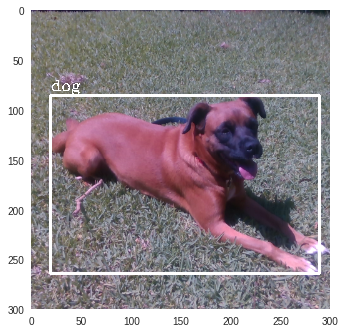

In [9]:
# Standard OpenCV boilerplate for running the net:
height, width = color.shape[:2]
expected = 300
aspect = width / height
resized_image = cv2.resize(color, (round(expected * aspect), expected))
crop_start = round(expected * (aspect - 1) / 2)
crop_img = resized_image[0:expected, crop_start:crop_start+expected]

net = cv2.dnn.readNetFromCaffe("MobileNetSSD_deploy.prototxt", "MobileNetSSD_deploy.caffemodel")
inScaleFactor = 0.007843
meanVal       = 127.53
classNames = ("background", "aeroplane", "bicycle", "bird", "boat",
              "bottle", "bus", "car", "cat", "chair",
              "cow", "diningtable", "dog", "horse",
              "motorbike", "person", "pottedplant",
              "sheep", "sofa", "train", "tvmonitor")

blob = cv2.dnn.blobFromImage(crop_img, inScaleFactor, (expected, expected), meanVal, False)
net.setInput(blob, "data")
detections = net.forward("detection_out")

label = detections[0,0,0,1]
conf  = detections[0,0,0,2]
xmin  = detections[0,0,0,3]
ymin  = detections[0,0,0,4]
xmax  = detections[0,0,0,5]
ymax  = detections[0,0,0,6]

className = classNames[int(label)]

cv2.rectangle(crop_img, (int(xmin * expected), int(ymin * expected)), 
             (int(xmax * expected), int(ymax * expected)), (255, 255, 255), 2)
cv2.putText(crop_img, className, 
            (int(xmin * expected), int(ymin * expected) - 5),
            cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,255,255))

plt.imshow(crop_img)

By projecting this data into the depth channel, we can now answer additional questions we couldn't approach before.

For example, with computer vision only it would be rather hard to make any meaningful predictions about **size and distance**.
You could train a model on average dog size per breed, but it would be easily fooled by toys of dogs or dogs of irregular proportions. Instead you can get this information directly when you have depth available!

Let's project our detected bounding box on to the depth image, and average the depth data inside it to get a sense of how close is the object:

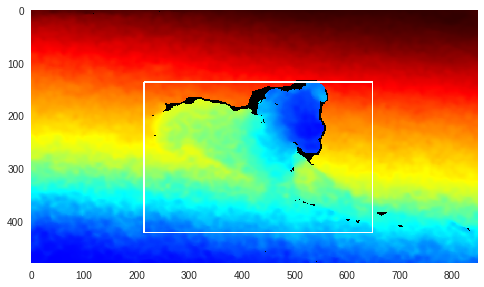

In [10]:
scale = height / expected
xmin_depth = int((xmin * expected + crop_start) * scale)
ymin_depth = int((ymin * expected) * scale)
xmax_depth = int((xmax * expected + crop_start) * scale)
ymax_depth = int((ymax * expected) * scale)
xmin_depth,ymin_depth,xmax_depth,ymax_depth
cv2.rectangle(colorized_depth, (xmin_depth, ymin_depth), 
             (xmax_depth, ymax_depth), (255, 255, 255), 2)
plt.imshow(colorized_depth)

In [11]:
depth = np.asanyarray(depth_frame.get_data())
# Crop depth data:
depth = depth[xmin_depth:xmax_depth,ymin_depth:ymax_depth].astype(float)

# Get data scale from the device and convert to meters
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
depth = depth * depth_scale
dist,_,_,_ = cv2.mean(depth)
print("Detected a {0} {1:.3} meters away.".format(className, dist))

Detected a dog 1.05 meters away.


This is a rather simple example, but it gives you a taste of what can be accomplished by combining depth with modern computer vision.

> **Want to learn more?** Visit [realsense.intel.com](http://realsense.intel.com) and [github.com/IntelRealSense](http://www.github.com/IntelRealSense/librealsense)